In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

import matplotlib as mpl
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['savefig.dpi'] = 1200
mpl.rcParams['text.usetex'] = True  # not really needed

np.random.seed(1000)

## Data & Setting: covariate and model shift

In [3]:
def get_covariate_shifted_data(n1, n2, p, sigma, scale=4):
    
    s_diag = scale * np.ones(p)
    for i in range(int(p/2), p):
        s_diag[i] = s_diag[i] / scale**2

    X2 = np.random.randn(n2, p)
    X1 = np.random.randn(n1, p) @ np.diag(s_diag)
    
    return X1, X2

## Estimates

In [4]:
def get_bias_plus_variance(X1, X2, n1, n2, p, sigma, d):
    K = np.linalg.inv(X1.T @ X1 + X2.T @ X2)
    variance = sigma**2 * np.trace(K)
    
    bias = (2.0 * d**2 / p) * (np.linalg.norm(K @ X1.T @ X1, 'fro') **2)
    return variance + bias


def estimates(c_1, c_2, sigma, cov_shift_scale, model_shift_scale):

    def get_coeff12(c_1, c_2, scale):
        d = (scale - 1.0/scale)**2
        coeff = [0 for i in range(4)]
        coeff[0] = -d  
        coeff[1] = d * (1 + (c_1 - 1.5)/(c_1 + c_2))
        coeff[2] = 1 - 1/(c_1 + c_2) - (1 - 1/(c_1 + c_2)) * ((c_1 - 0.5) / (c_1 + c_2)) * d
        coeff[3] = - (c_1/(c_1 + c_2)) * (1 - 1/(c_1 + c_2))**2
        A = np.roots(coeff)
        a_1 = -10
        num_valid = 0
        for a in A:
            if abs(np.imag(a)) <= 0.000001 and a > (c_1 - 1)/(c_1 + c_2) and a <= c_1/(c_1 + c_2) and a >= 0.0:
                if a != a_1: num_valid += 1            
                a_1 = a

        assert(num_valid == 1)
        a_2 = 1 - 1/(c_1 + c_2) - a_1
        return (a_1, a_2)
    
    def get_coeff34(a1, a2, cov_shift_scale):
        b1 = 1.0 / (cov_shift_scale**2 * a1 + a2) + 1.0 / (a1 / cov_shift_scale**2 + a2)
        b1 *= 1.0 / (2 * (c_1 + c_2))
        
        b2 = cov_shift_scale**2 / ((cov_shift_scale**2 * a1 + a2)**2) + (1.0 / cov_shift_scale**2) / ((a1 / (cov_shift_scale**2) + a2)**2)
        b2 *= 1.0 / (2 * (c_1 + c_2))
        
        a3 = (b2 * a1 + b2 * a1 * b1) / (1 + b2 * a2 + b2 * a1)
        a4 = ((1 + b2 * a2) * b1 - b2 * a1) / (1 + b2 * a2 + b2 * a1)
        return a3, a4
    
    var = 0.0
    
    # variance
    if cov_shift_scale == 1:
        a_1 = c_1 / float(c_1 + c_2)
        a_2 = (c_2 - 1) / float(c_1 + c_2)
        var = 1/ (c_1 + c_2 - 1)
    else:
        a_1, a_2 = get_coeff12(c_1, c_2, cov_shift_scale)
        scale_sq = cov_shift_scale**2
        var = 0.5 / ((c_1 + c_2) * (scale_sq * a_1 + a_2))
        var += 0.5 / ((c_1 + c_2) * (a_1 / scale_sq + a_2))

    var = var * sigma**2
    
    # bias
    a_3, a_4 = get_coeff34(a_1, a_2, cov_shift_scale)
    
    # print(a_1, a_2, a_3, a_4)
    eigs = (cov_shift_scale**4) * (a_3 * cov_shift_scale**2 + a_4 + 1) / ((a_1 * cov_shift_scale**2 + a_2) **2) \
           + (1.0 / cov_shift_scale**4) * (a_3 / cov_shift_scale**2 + a_4 + 1) / ((a_1 / cov_shift_scale**2 + a_2) **2)
    
    bias = (2 * model_shift_scale**2) * (c_1**2 / (2 * (c_1 + c_2)**2)) * eigs
    
    return var + bias

## new estimate

In [5]:
def get_new_estimate(n1, n2, p, l_shift, sigma, mu):
    if n1 == 0:
        return sigma**2 * p / (n2 - p)
    
    n1 = float(n1)
    n2 = float(n2)
    p = float(p)
    coeff = [0 for i in range(4)]
    coeff[0] = n2 * l_shift**2 / n1
    coeff[1] = (2 * n2 - p) * (l_shift**4 + 1) / (2 * n1) + (p / n1 - 1) * l_shift**2
    coeff[2] = (n2 - p) * l_shift**2 / n1 + (p / (2* n1) - 1) * (l_shift**4 + 1)
    coeff[3] = -l_shift**2    
    A = np.roots(coeff)
#    print(A)

    y = -10
    num_valid = 0
    for a in A:
        if  a >= 0.0:
            num_valid += 1
            y = a

    assert(num_valid == 1)
    
    g0 = (p / (2 * n1)) * (l_shift**2 / (1 + l_shift**2 * y) + 1 / (l_shift**2 + y)) - 1 / y
    f1 = n1 * y / p + (n1 - p) / (p * g0)
    
    g0_prime = (-p / (n1 * 2)) * (l_shift**4 / (1 + l_shift**2 * y)**2 + 1 / (l_shift**2 + y)**2) + 1 / (y**2)
    f2 = n1 / (p * g0_prime) - (n1 - p) / (p * g0**2)
    
    f3 = -g0
    
#    print(y, (n1 + n2 - p) / n1 + g0 * (1 + y))
    
    var = sigma**2 * p * f1 / n1
    bias = (2 * mu**2) * (1 - 2 * f1 * f3 + f2 * f3**2) / (1 - f2 * f3**2 * p / n2)
    
    return var + bias

get_new_estimate(200, 500, 200, 4, 0.5, 0)

0.07501164276562744

## Figure 4a: reproduce figure 2b in the covariate-shifted setting

/Users/hongyang/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


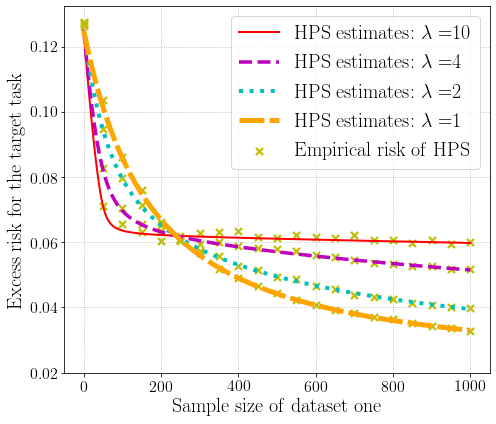

In [9]:
def run(n1_list, n2, p, sigma, cov_shift_scale, model_shift_scale):
    emp_list = []

    for n1 in n1_list:
        X1, X2 = get_covariate_shifted_data(n1, n2, p, sigma, cov_shift_scale)
    
        emp_risk = get_bias_plus_variance(X1, X2, n1, n2, p, sigma, model_shift_scale)
        emp_list.append(emp_risk)
        
    return emp_list

def get_estimates(n1_list, n2, p, sigma, cov_shift_scale, model_shift_scale):
    thy_list = []
    
    for n1 in n1_list:    
#        thy_risk = estimates(float(n1) / p, float(n2) / p, sigma, cov_shift_scale, model_shift_scale)
        thy_risk = get_new_estimate(n1, n2, p, cov_shift_scale, sigma, model_shift_scale)
        thy_list.append(thy_risk)
    
    return thy_list

p = 100
n2 = 300
sigma = 0.5
mu = 0.1
        
N = 20
n1_list = np.array([i * 50 for i in range(0, N + 1)])
n1_extended_list = np.array([i * 5 for i in range(0, N*10 + 1)])
scale_list = [10, 4, 2, 1]


plt.figure(figsize=(7,6))
colors = ['r', 'm', 'c', 'orange']
linestyles = ['solid', 'dashed', 'dotted', (0, (5, 1))]
linewidths = [2, 3.5, 4, 5]


for i, cov_shift_scale in enumerate(scale_list):
    emp_list = run(n1_list, n2, p, sigma, cov_shift_scale, mu)
    thy_list = get_estimates(n1_extended_list, n2, p, sigma, cov_shift_scale, mu)
    
    if i == 0:
        plt.scatter(n1_list, emp_list, marker='x', c='y',  s=50, lw=2.2, label=r'$\mathrm{Empirical~risk~of~HPS}$')
    else:
        plt.scatter(n1_list, emp_list, marker='x', c='y',  s=50, lw=2.2)
        
    plt.plot(n1_extended_list, thy_list, c=colors[i], ls=linestyles[i], lw=linewidths[i], label=r'$\mathrm{HPS~estimates}$' + r'$:\lambda = $' + '$\mathrm{'+str(cov_shift_scale)+'}$')

plt.xlabel(r'$\mathrm{Sample~size~of~dataset~one}$', fontsize=20)
plt.ylabel(r'$\mathrm{Excess~risk~for~the~target~task}$', fontsize=20)

plt.yticks(np.arange(0.02, 0.13, 0.02), fontsize=16)
plt.xticks(np.arange(0, 1100, 200), fontsize=16)
#plt.ylim([0.03, 0.105])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=20)#,loc=3)
plt.tight_layout()
plt.savefig('covariate_and_model_shift_a.eps')    

## Figure 4b: reproduce figure 3b in the model shift setting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


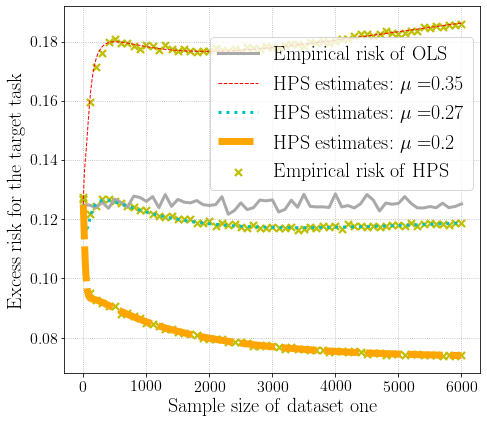

In [14]:
l_scale = 4
mu_list = [0.35, 0.27, 0.2]

plt.figure(figsize=(7,6))

N = 60
n1_list = np.array([i * 100 for i in range(0, N + 1)])
n1_extended_list = np.array([i * 10 for i in range(0, N*10 + 1)])


ols_list = []
for n1 in n1_list:
    X2 = np.random.randn(n2, p)
    ols_list.append(sigma**2 * np.trace( np.linalg.inv(X2.T @ X2) ))

#ols_list = [sigma**2 * p / (n2 - p) for i in n1_list]
plt.plot(n1_list, ols_list, c='darkgrey', lw=3, label=r'$\mathrm{Empirical~risk~of~OLS}$')
colors = ['r', 'c', 'orange']
linewidths = [2, 1, 3, 7]


for i, mu in enumerate(mu_list):
    emp_list = run(n1_list, n2, p, sigma, l_scale, mu)
    thy_list = get_estimates(n1_extended_list, n2, p, sigma, l_scale, mu)
    
    if i == 0:
        plt.scatter(n1_list, emp_list, marker='x', c='y',  s=50, lw=2.2, label=r'$\mathrm{Empirical~risk~of~HPS}$')
    else:
        plt.scatter(n1_list, emp_list, marker='x', c='y',  s=50, lw=2.2)
        
    plt.plot(n1_extended_list, thy_list, c=colors[i], ls=linestyles[i+1], lw=linewidths[i+1], label=r'$\mathrm{HPS~estimates}$' + r'$:\mu = $' + r'$\mathrm{'+str(mu)+'}$')
    i += 1

plt.xlabel(r'$\mathrm{Sample~size~of~dataset~one}$', fontsize=20)
plt.ylabel(r'$\mathrm{Excess~risk~for~the~target~task}$', fontsize=20)
    
plt.yticks(np.arange(0.08, 0.19, 0.02), fontsize=16)
plt.xticks(np.arange(0, 6100, 1000), fontsize=16)
#plt.ylim([0.03, 0.105])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=20,loc=(0.35,0.5))
plt.tight_layout()
plt.savefig('covariate_and_model_shift_b.eps')    